In [8]:
from matplotlib.ticker import FuncFormatter
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime,timedelta
import re
import os

## Initializing Weather Data

### Loading weather & trips

In [9]:
status_final = pd.read_csv(r'C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Clean Data\2024-02_Assign to parkinglot_Final_Status.csv')
weather_original = pd.read_csv(r'C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Data Weather\2024-02_data_weather.csv')

trips = status_final
weather_raw = weather_original

In [10]:
weather_raw.head(5)

,תחנה,תאריך ושעה (שעון קיץ),טמפרטורה (C°),טמפרטורת מקסימום (C°),טמפרטורת מינימום (C°),כיוון הרוח (מעלות),מהירות רוח (מטר לשניה),"כמות גשם (מ""מ)"
0,"תל-אביב, חוף",01/02/2024 00:00,9.9,10.0,9.9,120,2.6,0.0
1,"תל-אביב, חוף",01/02/2024 00:10,9.9,10.0,9.9,121,2.4,0.0
2,"תל-אביב, חוף",01/02/2024 00:20,10.0,10.0,9.9,122,2.9,0.0
3,"תל-אביב, חוף",01/02/2024 00:30,9.9,10.0,9.9,122,2.7,0.0
4,"תל-אביב, חוף",01/02/2024 00:40,9.9,10.0,9.8,124,2.8,0.0


### Convert weather data resolution to 30 min intervals

In [11]:
# Hebrew -> English 
col_rename_map = {
    'תחנה': 'station',
    'תאריך ושעה (שעון קיץ)': 'datetime',
    'טמפרטורה (C°)': 'temp_c',
    'טמפרטורת מקסימום (C°)': 'temp_max_c',
    'טמפרטורת מינימום (C°)': 'temp_min_c',
    'כיוון הרוח (מעלות)': 'wind_direction_deg',
    'מהירות רוח (מטר לשניה)': 'wind_speed_ms',
    'כמות גשם (מ"מ)': 'rain_mm'
}

# Column rename to English
weather_raw = weather_raw.rename(columns=col_rename_map)
weather_raw.drop(['station'], axis=1, inplace=True)


In [12]:
weather_raw.head(2)

,datetime,temp_c,temp_max_c,temp_min_c,wind_direction_deg,wind_speed_ms,rain_mm
0,01/02/2024 00:00,9.9,10.0,9.9,120,2.6,0.0
1,01/02/2024 00:10,9.9,10.0,9.9,121,2.4,0.0


In [13]:
import pandas as pd

# Convert the 'datetime' column from string to a proper datetime object
weather_raw['datetime'] = pd.to_datetime(weather_raw['datetime'], dayfirst=True)

# Create a new column 'datetime_30' that rounds down each timestamp
# to the start of a 30-minute interval (00:00, 00:30, 01:00, etc.).
weather_raw['datetime_30'] = weather_raw['datetime'].dt.floor('30T')  # '30T' = 30 minutes

# Aggregate the data to 30-minute resolution:
#  - Group by 'datetime_30' (each 30-minute window)
#  - For each group of 3 rows (10-min steps):
#        * temp_c:      average temperature
#        * temp_max_c:  maximum temperature
#        * temp_min_c:  minimum temperature
#        * wind_direction_deg: average wind direction
#        * wind_speed_ms:      average wind speed
#        * rain_mm:            sum of rain in that 30-minute window
weather = (
    weather_raw
    .groupby('datetime_30')
    .agg(
        temp_c=('temp_c', 'mean'),                     # average temperature over 30 minutes
        temp_max_c=('temp_max_c', 'max'),              # highest temp in the 30-min window
        temp_min_c=('temp_min_c', 'min'),              # lowest temp in the 30-min window
        wind_direction_deg=('wind_direction_deg', 'mean'),  # average wind direction
        wind_speed_ms=('wind_speed_ms', 'mean'),       # average wind speed
        rain_mm=('rain_mm', 'sum')                     # total rain in 30 minutes
    )
    .reset_index()
    .rename(columns={'datetime_30': 'datetime'})       # rename back to 'datetime' for clarity
)

# Quick check: show the first 5 rows of the 30-minute resolution dataset
print(weather.head())


             datetime    temp_c  temp_max_c  temp_min_c  wind_direction_deg  \
0 2024-02-01 00:00:00  9.933333        10.0         9.9          121.000000   
1 2024-02-01 00:30:00  9.900000        10.0         9.8          123.666667   
2 2024-02-01 01:00:00  9.700000         9.9         9.6          124.333333   
3 2024-02-01 01:30:00  9.433333         9.6         9.3          120.000000   
4 2024-02-01 02:00:00  9.333333         9.5         9.2          118.333333   

   wind_speed_ms  rain_mm  
0       2.633333      0.0  
1       2.766667      0.0  
2       2.466667      0.0  
3       3.033333      0.0  
4       2.733333      0.0  


C:\Users\Aviya\AppData\Local\Temp\ipykernel_21756\3663084359.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_raw['datetime_30'] = weather_raw['datetime'].dt.floor('30T')  # '30T' = 30 minutes


In [14]:
# save as csv to clean data 
weather.to_csv(r'C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Clean Data\2024-02_Final_Weather.csv', index=False)

### General calculations for graph use

In [790]:
# Ensure datetime columns are parsed once
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')
trips['end_time']   = pd.to_datetime(trips['end_time'], errors='coerce')

In [791]:
# Compute daily aggregated weather metric (e.g. rain, wind, temperature)
def prepare_daily_metric(weather_df, metric_col, time_col='datetime', agg='sum'):
    daily = (
        weather_df
        .set_index(time_col)
        .resample('D')[metric_col]
        .agg(agg)
        .reset_index()
        .rename(columns={time_col: 'date', metric_col: 'value'})
    )
    return daily  # columns: ['date', 'value']

In [792]:
# Get time window from first to last non-zero day (+ extra_days)
def get_nonzero_window(daily_df, value_col='value', extra_days=3):
    first = daily_df.loc[daily_df[value_col] != 0, 'date'].min()
    last  = daily_df.loc[daily_df[value_col] != 0, 'date'].max()

    start = first.normalize()
    end   = (last + pd.Timedelta(days=extra_days)).normalize()
    return start, end

In [793]:
# Compute hourly trip counts for trip_start events in the given window
def prepare_hourly_trips(trips_df, start, end):
    mask_time = (trips_df['end_time'] >= start) & (trips_df['end_time'] <= end)
    mask_type = (trips_df['event_types'] == 'trip_start')
    df = trips_df.loc[mask_time & mask_type]

    full_idx = pd.date_range(start=start,
                             end=end + pd.Timedelta(days=1),
                             freq='H')

    hourly = (
        df.set_index('end_time')
          .resample('H').size()
          .reindex(full_idx, fill_value=0)
          .rename_axis('end_time')
          .reset_index(name='trip_count')
    )
    return hourly  # ['end_time', 'trip_count']

In [794]:
# Compute hourly aggregated weather metric (e.g. rain, wind, temperature)
def prepare_hourly_metric(weather_df, metric_col, start, end, time_col='datetime', agg='sum'):
    hourly = (
        weather_df
        .set_index(time_col)
        .resample('H')[metric_col]
        .agg(agg)
        .reset_index()
    )

    mask_time = (hourly[time_col] >= start) & (hourly[time_col] <= end + pd.Timedelta(days=1))
    hourly = hourly.loc[mask_time]

    hourly = hourly.rename(columns={time_col: 'datetime', metric_col: 'value'})
    return hourly  # ['datetime', 'value']

In [795]:
# Merge hourly trips and hourly metric on timestamp
def merge_hourly(hourly_trips, hourly_metric):
    merged = pd.merge(
        hourly_trips,
        hourly_metric,
        left_on='end_time',
        right_on='datetime',
        how='left'
    ).drop(columns=['datetime'])
    return merged  # has 'end_time', 'trip_count', 'value

In [796]:
# Aggregate hourly trips to daily counts
def prepare_daily_trips(hourly_trips_df):
    df = hourly_trips_df.copy()
    df['date'] = df['end_time'].dt.floor('D')
    daily = (
        df.groupby('date', as_index=False)['trip_count']
          .sum()
    )
    return daily  # ['date', 'trip_count']

## Line / Bar Charts

### Create Line/Bar Chart with Dual Y-Axes (Generic)

In [797]:
def plot_trips_and_multi_metrics(
    trips_df,
    metrics,
    start,
    end,
    resolution='hourly',
    trips_label=None,
    trips_style='line',
    figsize=(20, 5),
    show_hourly_secondary_axis=False,
    title=None,
    save_to_png=True, 
    png_dir=r'C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs'
):
    fig, ax = plt.subplots(figsize=figsize)

    # --- X & Y for trips ---
    if resolution == 'hourly':
        x_trips = trips_df['end_time']
        x_name = "time"
        ylabel_trips = 'Trips per hour'
        if trips_label is None:
            trips_label = 'Trips per hour'
    elif resolution == 'daily':
        x_trips = trips_df['date']
        x_name = "date"
        ylabel_trips = 'Trips per day'
        if trips_label is None:
            trips_label = 'Trips per day'
    else:
        raise ValueError("resolution must be 'hourly' or 'daily'")

    # --- Left Y: trips ---
    if trips_style == 'line':
        ax.plot(
            x_trips,
            trips_df['trip_count'],
            color='black',
            linewidth=1.6,
            label=trips_label
        )
    elif trips_style == 'bar':
        ax.bar(
            x_trips,
            trips_df['trip_count'],
            width=0.03 if resolution == 'hourly' else 0.6,
            label=trips_label
        )

    ax.set_ylabel(ylabel_trips)

    # === AUTO TITLE / MANUAL TITLE ===
    if title is None:
        # Collect right-axis labels from metrics
        y2_labels = [m.get('label', 'Metric') for m in metrics]

        if len(y2_labels) == 1:
            y2_part = f'"{y2_labels[0]}"'
        else:
            y2_part = ', '.join(f'"{y}"' for y in y2_labels[:-1])
            y2_part += f' and "{y2_labels[-1]}"'

        auto_title = f'"{trips_label}" as a function of "{x_name}" vs {y2_part}'
        final_title = auto_title
        ax.set_title(auto_title)
    else:
        # If a manual title was provided, still collect labels for Y2 axis
        y2_labels = [m.get('label', 'Metric') for m in metrics]
        final_title = title
        ax.set_title(title)

    # Compact right-axis label (for Y2)
    if len(y2_labels) == 1:
        y2_label = y2_labels[0]
    else:
        # Short combined label, e.g. "Daily MIN temp (°C) / Daily MAX temp (°C)"
        y2_label = " / ".join(y2_labels)
    # === END TITLE ===



    # --- Right Y: metrics ---
    ax2 = ax.twinx()
    for m in metrics:
        df = m['df']
        time_col = m.get('time_col', 'date' if resolution == 'daily' else 'datetime')
        value_col = m.get('value_col', 'value')
        label = m.get('label', 'Metric')
        color = m.get('color', 'royalblue')
        style = m.get('style', 'line')

        x_metric = df[time_col]

        if style == 'line':
            ax2.plot(
                x_metric,
                df[value_col],
                color=color,
                linewidth=2,
                marker='o',
                label=label
            )
        elif style == 'bar':
            ax2.bar(
                x_metric,
                df[value_col],
                width=0.6 if resolution == 'daily' else 0.03,
                alpha=0.7,
                label=label
            )

    ax2.set_ylabel(y2_label)
    ax2.set_ylim(bottom=0)

    # --- X-axis formatting ---
    if resolution == 'daily':
        ax.set_xlim([start, end])
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

    elif resolution == 'hourly':
        # Limit x-axis to the selected time window
        ax.set_xlim([start, end])

        if show_hourly_secondary_axis:
            # --- Advanced hourly style: hours on main axis, dates on secondary axis ---

            # Major ticks = days (used for vertical lines, labels hidden)
            ax.xaxis.set_major_locator(mdates.DayLocator())
            ax.tick_params(axis='x', which='major', labelbottom=False)

            # Minor ticks = selected hours (00:00, 09:00, 17:00) with labels
            ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 9, 17]))
            ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
            ax.tick_params(axis='x', which='minor', labelsize=8, pad=4)

            # Secondary x-axis at the bottom showing dates (day-month-year, English)
            ax_dates = ax.secondary_xaxis('bottom')
            ax_dates.xaxis.set_major_locator(mdates.DayLocator())
            ax_dates.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))  # e.g. 01-Feb-2024
            ax_dates.tick_params(axis='x', pad=22, labelsize=9)

            # Vertical midnight lines for visual separation
            for day in pd.date_range(
                start.normalize(),
                end.normalize() + pd.Timedelta(days=1),
                freq='D'
            ):
                ax.axvline(day, linestyle='--', linewidth=0.8, alpha=0.25)

        else:
            # --- Simple style: only dates on the main axis, no hours ---

            # Compute number of days in the window and choose a step to avoid clutter
            num_days = (end.normalize() - start.normalize()).days + 1
            step = max(1, num_days // 8)

            ax.xaxis.set_major_locator(mdates.DayLocator(interval=step))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))  # e.g. 01-Feb-2024
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)


    # --- Grid ---
    ax.grid(axis='x', which='major', alpha=0.12)
    ax.grid(axis='y', alpha=0.25)

    # --- Combined legend ---
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

    plt.tight_layout()

    # --- save to PNG ---
    if save_to_png:
        # make sure directory exists
        os.makedirs(png_dir, exist_ok=True)
        # sanitize title to filename
        safe_title = re.sub(r'[^A-Za-z0-9_\-]+', '_', final_title)
        filename = f"{safe_title}.png"
        filepath = os.path.join(png_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"Saved figure to: {filepath}")

    plt.show()

### Graph's "main"

#### Trips - Rain Daily resolution through the month

In [798]:
# Daily rain (sum per day)
daily_rain = prepare_daily_metric(
    weather_df=weather,
    metric_col='rain_mm',
    time_col='datetime',
    agg='sum'
)

# Window where rain != 0 + extra dry days
start, end = get_nonzero_window(daily_rain, value_col='value', extra_days=4)
#start = pd.Timestamp('2024-02-01')
#end   = pd.Timestamp('2024-02-08')
print("Rain window:", start, "->", end)

daily_rain_win = daily_rain[
    (daily_rain['date'] >= start) &
    (daily_rain['date'] <= end)
]


hourly_trips = prepare_hourly_trips(trips_df=trips, start=start, end=end)
daily_trips = prepare_daily_trips(hourly_trips)


metrics = [
    {
        'df': daily_rain_win,
        'time_col': 'date',
        'value_col': 'value',
        'label': 'Daily rain (mm)',
        'color': 'royalblue',
        'style': 'line'
    }
]

Rain window: 2024-02-01 00:00:00 -> 2024-02-24 00:00:00


C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start,
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').size()


Saved figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\_Trips_per_day_as_a_function_of_date_vs_Daily_rain_mm_.png


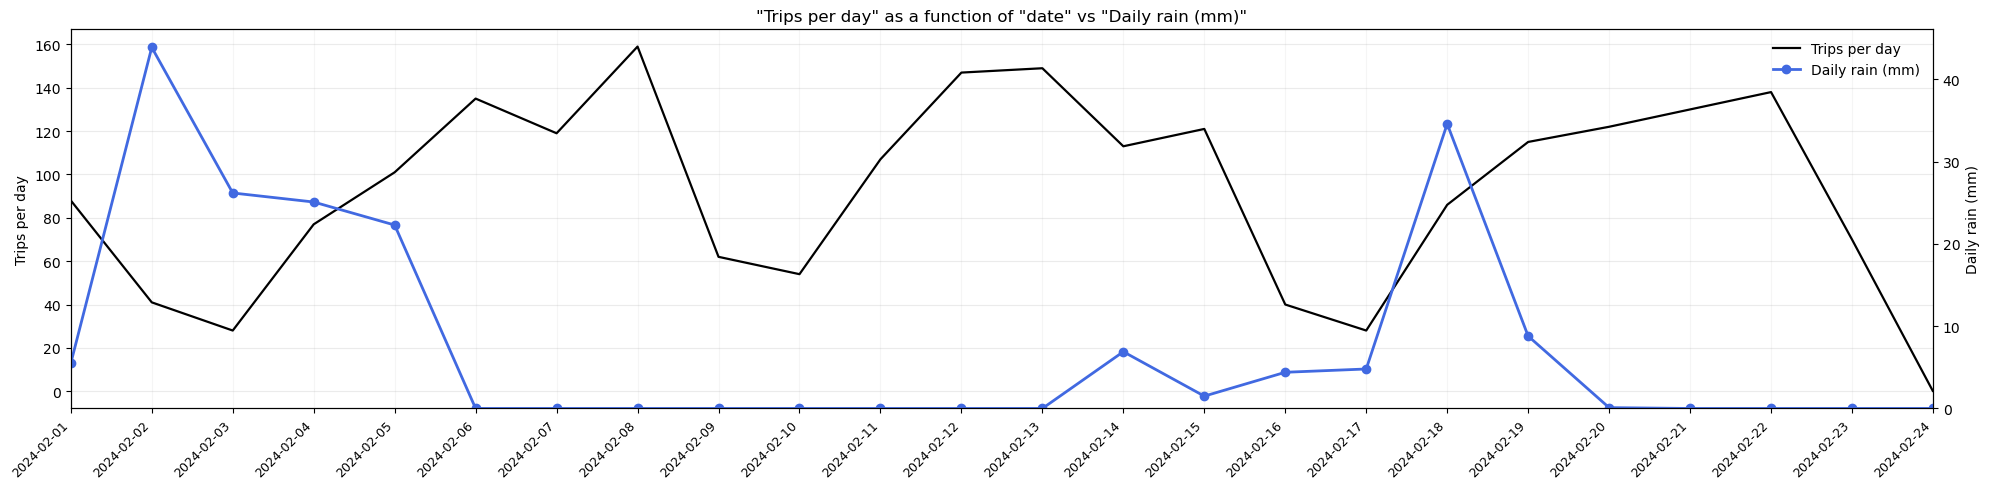

In [799]:
plot_trips_and_multi_metrics(
    trips_df=daily_trips,
    metrics=metrics,
    start=start,
    end=end,
    resolution='daily',
    trips_style='line'
)

#### Zoom In -> Trips - Rain Hourly resolution

In [800]:
# === 1. Daily rain to detect rainy days ===
daily_rain = prepare_daily_metric(
    weather_df=weather,
    metric_col='rain_mm',
    time_col='datetime',
    agg='sum'
)

# Window
start = pd.Timestamp('2024-02-01')   # 2024-02-02 00:00:00
end   = pd.Timestamp('2024-02-06')   # 2024-02-10 00:00:00
print("Rainy window (hourly zoom):", start, "->", end)

# === 2. Hourly trips in this rainy window ===
hourly_trips = prepare_hourly_trips(
    trips_df=trips,
    start=start,
    end=end
)

# === 3. Hourly rain in same window ===
hourly_rain = prepare_hourly_metric(
    weather_df=weather,
    metric_col='rain_mm',
    start=start,
    end=end,
    time_col='datetime',
    agg='sum'          # total rain per hour
)

# === 4. Build metrics list for the generic plotting function ===
metrics = [
    {
        'df': hourly_rain,
        'time_col': 'datetime',
        'value_col': 'value',
        'label': 'Rain (mm/hour)',
        'color': 'royalblue',
        'style': 'line'    # hourly rain as bars (spikes)
    }
]

Rainy window (hourly zoom): 2024-02-01 00:00:00 -> 2024-02-06 00:00:00


C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start,
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').size()
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2669063900.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')[metric_col]


Saved figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\_Trips_per_hour_as_a_function_of_time_vs_Rain_mm_hour_.png


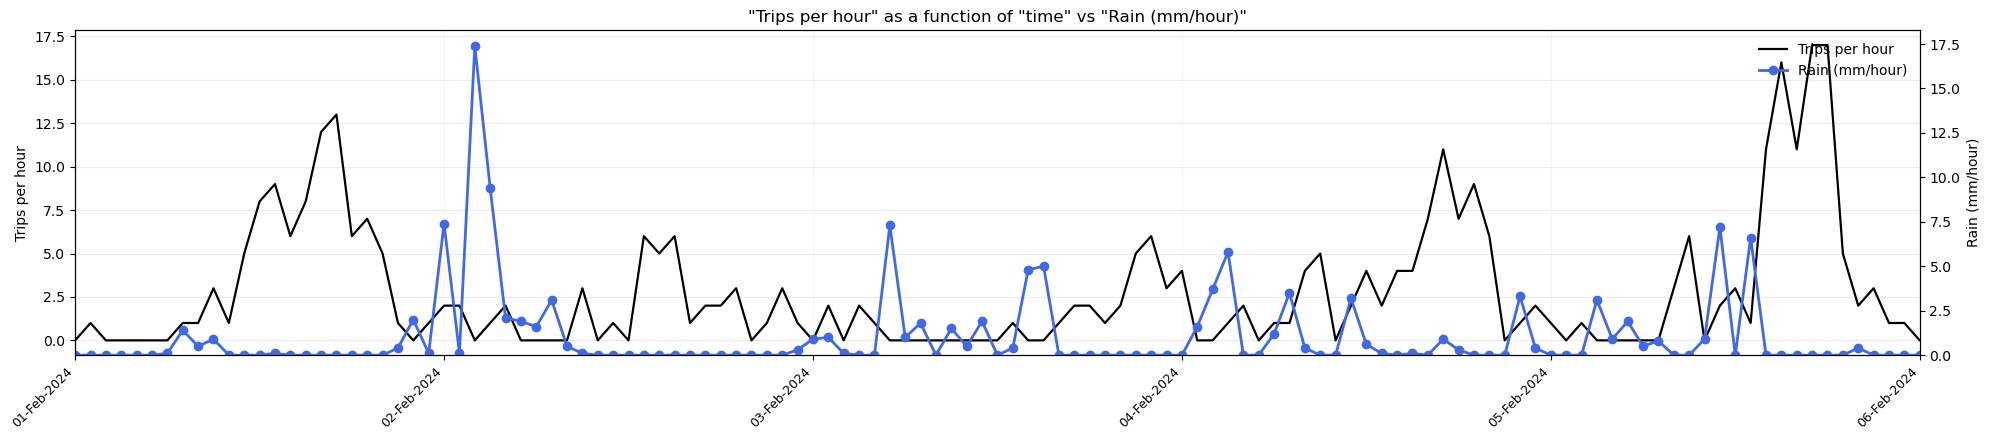

In [801]:
# Plot: hourly trips (left Y) + hourly rain (right Y), zoomed on rainy days
plot_trips_and_multi_metrics(
    trips_df=hourly_trips,
    metrics=metrics,
    start=start,
    end=end,
    resolution='hourly',   
    trips_style='line',    
    figsize=(20, 4.5),
)

#### Trips - Rain through Daily hours

In [802]:
# Daily rain to detect rainy days
daily_rain = prepare_daily_metric(
    weather_df=weather,
    metric_col='rain_mm',
    time_col='datetime',
    agg='sum'
)

# Choose window
start = pd.Timestamp('2024-02-01 08:00')
end   = pd.Timestamp('2024-02-08 23:00')
print("Rainy window (hourly zoom):", start, "->", end)

# Hourly trips in this window
hourly_trips = prepare_hourly_trips(
    trips_df=trips,
    start=start,
    end=end
)

# Hourly rain in this window
hourly_rain = prepare_hourly_metric(
    weather_df=weather,
    metric_col='rain_mm',
    start=start,
    end=end,
    time_col='datetime',
    agg='sum'  
)

# Metrics list for the right Y-axis
metrics = [
    {
        'df': hourly_rain,
        'time_col': 'datetime',
        'value_col': 'value',
        'label': 'Rain (mm/hour)',
        'color': 'royalblue',
        'style': 'line'  
    }
]

Rainy window (hourly zoom): 2024-02-01 08:00:00 -> 2024-02-08 23:00:00


C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start,
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').size()
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2669063900.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')[metric_col]


Saved figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\_Trips_per_hour_as_a_function_of_time_vs_Rain_mm_hour_.png


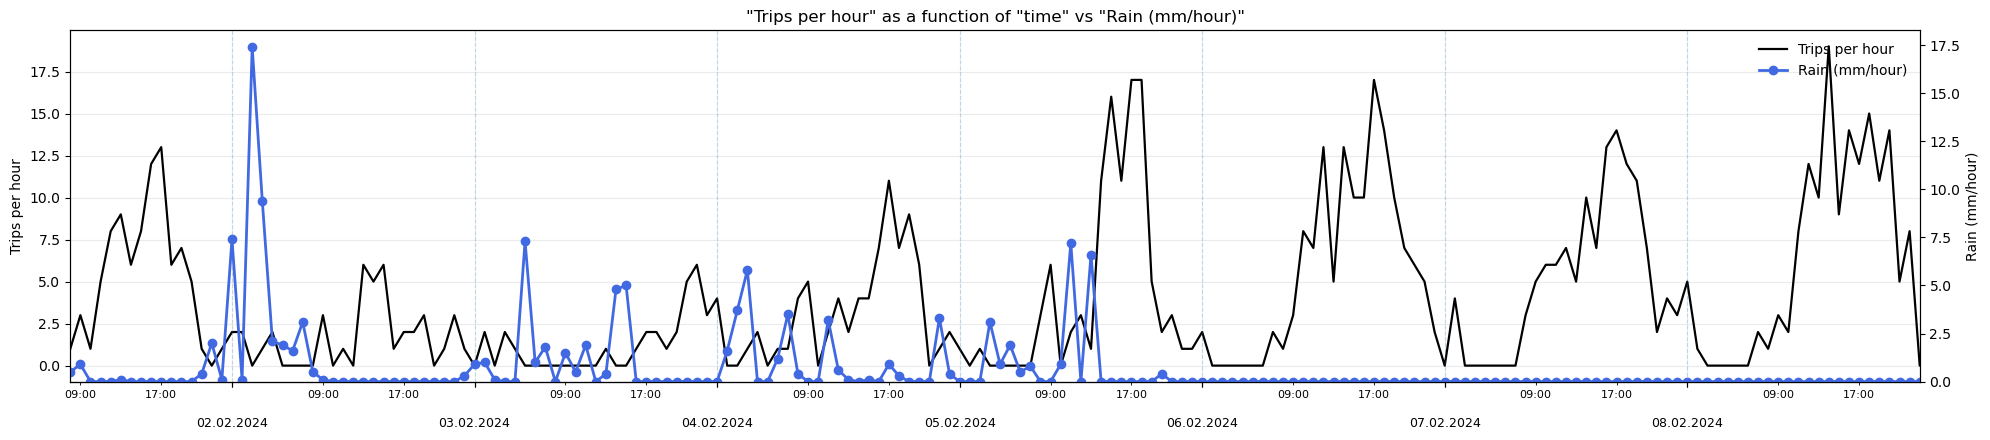

In [803]:
plot_trips_and_multi_metrics(
    trips_df=hourly_trips,
    metrics=metrics,
    start=start,
    end=end,
    resolution='hourly',
    trips_style='line',
    show_hourly_secondary_axis=True,
    figsize=(20, 4.5)
)

#### Min - Max temp through month

In [804]:
# Daily MIN temperature
daily_temp_min = prepare_daily_metric(
    weather_df=weather,
    metric_col='temp_min_c',
    time_col='datetime',
    agg='min'
)

# Daily MAX temperature
daily_temp_max = prepare_daily_metric(
    weather_df=weather,
    metric_col='temp_max_c',
    time_col='datetime',
    agg='max'
)

# Choose window (e.g. based on max temp)
start, end = get_nonzero_window(daily_temp_max, value_col='value', extra_days=0)
print("Temp window:", start, "->", end)

daily_temp_min_win = daily_temp_min[
    (daily_temp_min['date'] >= start) &
    (daily_temp_min['date'] <= end)
]
daily_temp_max_win = daily_temp_max[
    (daily_temp_max['date'] >= start) &
    (daily_temp_max['date'] <= end)
]

hourly_trips = prepare_hourly_trips(trips_df=trips, start=start, end=end)

# Hourly rain in the same window (start–end)
hourly_rain = prepare_hourly_metric(
    weather_df=weather,
    metric_col='rain_mm',
    start=start,
    end=end,
    time_col='datetime',
    agg='sum'   # total rain per hour
)

metrics = [
    {
        'df': daily_temp_min_win,
        'time_col': 'date',
        'value_col': 'value',
        'label': 'Daily MIN temp (°C)',
        'color': 'royalblue',
        'style': 'line'
    },
    {
        'df': daily_temp_max_win,
        'time_col': 'date',
        'value_col': 'value',
        'label': 'Daily MAX temp (°C)',
        'color': 'orange',
        'style': 'line'
    },
    {
        'df': hourly_rain,
        'time_col': 'datetime', 
        'value_col': 'value',
        'label': 'Rain per hour (mm)',
        'color': 'green',
        'style': 'line'
    }
]


Temp window: 2024-02-01 00:00:00 -> 2024-03-01 00:00:00


C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start,
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').size()
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2669063900.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')[metric_col]


Saved figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\_Trips_per_hour_as_a_function_of_time_vs_Daily_MIN_temp_C_Daily_MAX_temp_C_and_Rain_per_hour_mm_.png


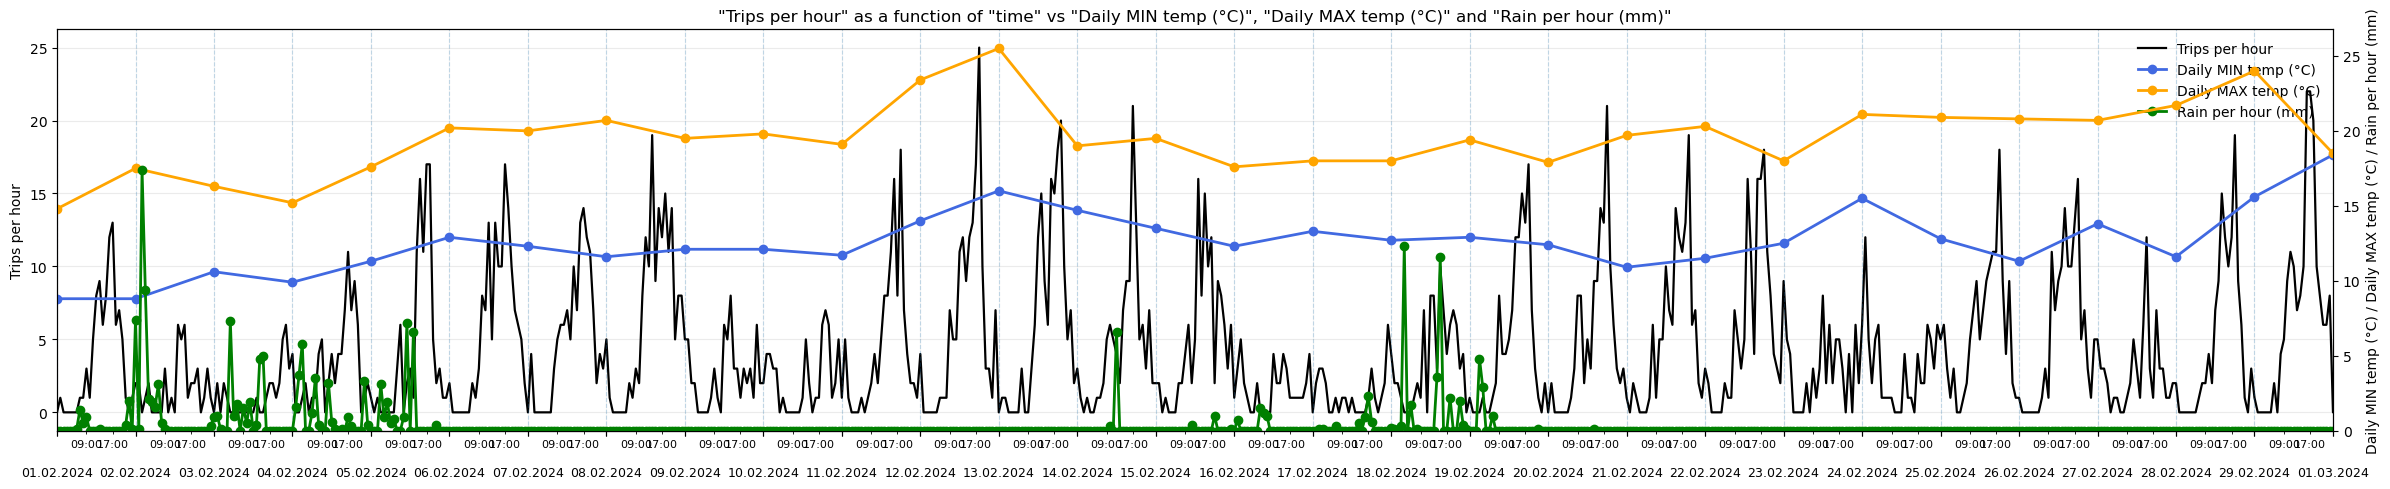

In [805]:
plot_trips_and_multi_metrics(
    trips_df=hourly_trips,
    metrics=metrics,
    start=start,
    end=end,
    resolution='hourly',
    trips_style='line',
    show_hourly_secondary_axis=True,
    figsize=(24, 5)
    #right_ylabel='Temperature (°C) / Rain per hour (mm)'
)


Saved figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\_Trips_per_hour_as_a_function_of_time_vs_Daily_MIN_temp_C_Daily_MAX_temp_C_and_Rain_per_hour_mm_.png


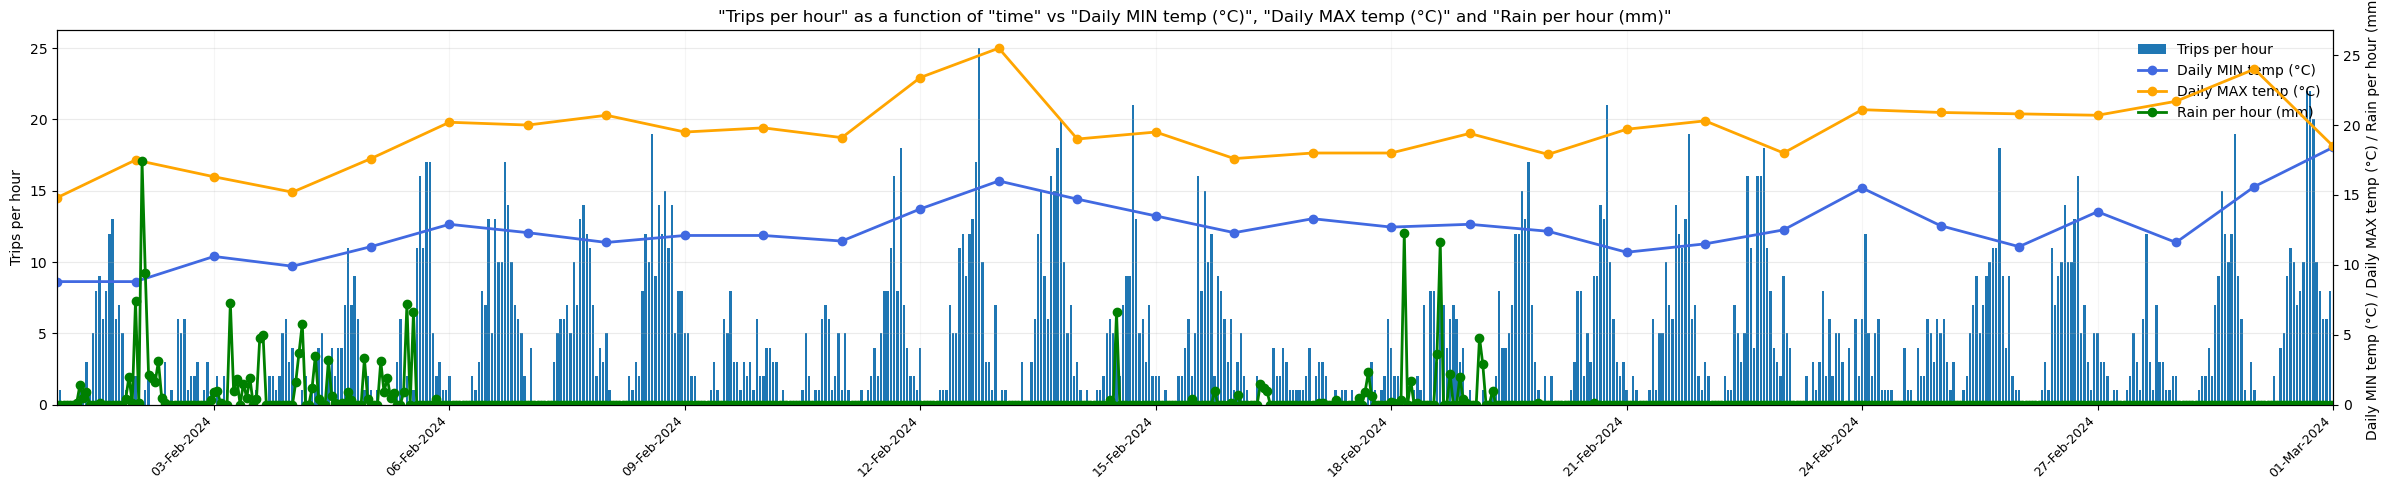

In [806]:
plot_trips_and_multi_metrics(
    trips_df=hourly_trips,
    metrics=metrics,
    start=start,
    end=end,
    resolution='hourly',
    trips_style='bar',
    figsize=(24, 5)
    #right_ylabel='Temperature (°C) / Rain per hour (mm)'
)

#### Trips - Avarege speed through month

In [807]:
# Daily average wind speed
daily_wind = prepare_daily_metric(
    weather_df=weather,
    metric_col='wind_speed_ms',
    time_col='datetime',
    agg='mean'
)

start, end = get_nonzero_window(daily_wind, value_col='value', extra_days=2)
print("Wind window:", start, "->", end)

daily_wind_win = daily_wind[
    (daily_wind['date'] >= start) &
    (daily_wind['date'] <= end)
]

# Hourly trips -> aggregate to daily
hourly_trips = prepare_hourly_trips(trips_df=trips, start=start, end=end)
daily_trips = prepare_daily_trips(hourly_trips)

metrics = [
    {
        'df': daily_wind_win,
        'time_col': 'date',
        'value_col': 'value',
        'label': 'Daily avg wind (m/s)',
        'color': 'green',
        'style': 'line'
    }
]

Wind window: 2024-02-01 00:00:00 -> 2024-03-03 00:00:00


C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start,
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2307823829.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').size()


Saved figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\_Trips_per_day_as_a_function_of_date_vs_Daily_avg_wind_m_s_.png


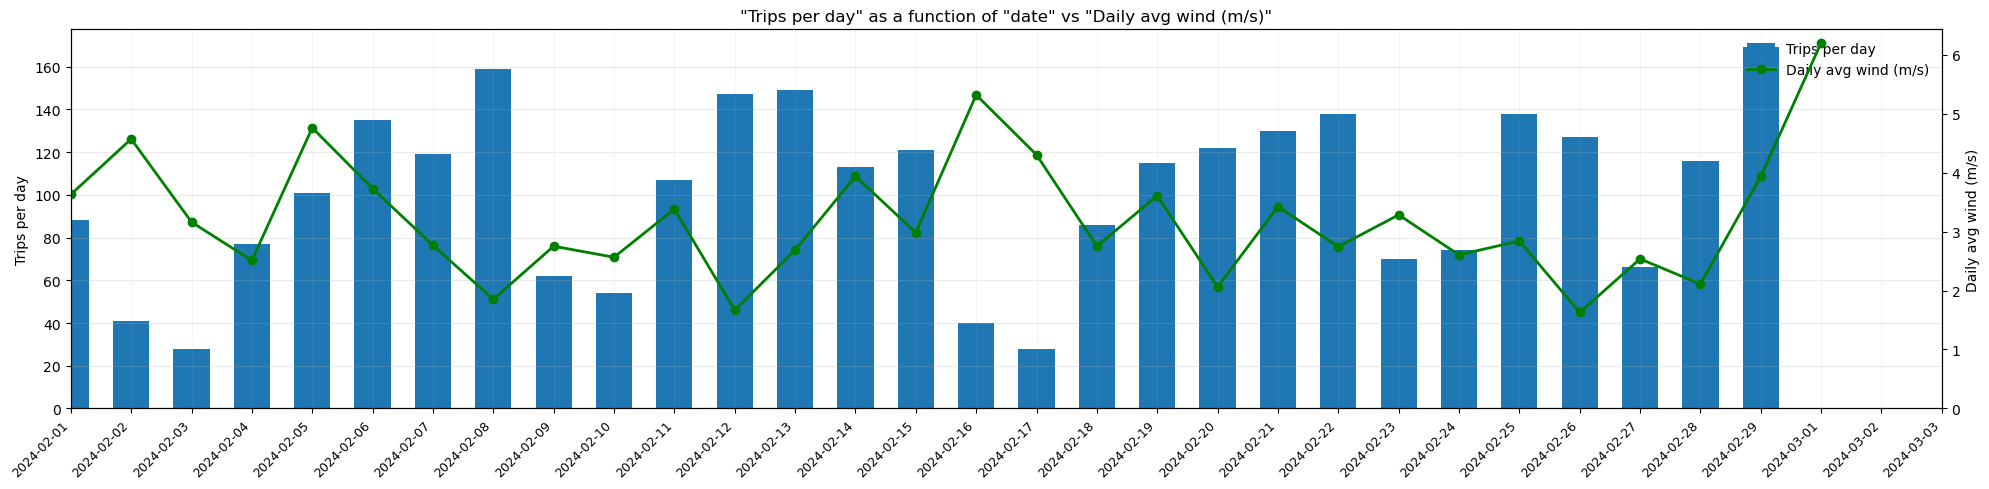

In [808]:
plot_trips_and_multi_metrics(
    trips_df=daily_trips,
    metrics=metrics,
    start=start,
    end=end,
    resolution='daily',  
    trips_style='bar'     
)

# Scatter Plots

### More General Calculations - To Move When Finished

In [809]:
# --- Add basic time features to trips ---
def add_time_features_trips(trips_df, time_col='end_time'):
    df = trips_df.copy()
    df['date'] = df[time_col].dt.floor('D')
    df['hour'] = df[time_col].dt.hour
    df['day_of_month'] = df[time_col].dt.day
    df['weekday'] = df[time_col].dt.dayofweek  # 0=Mon
    return df


# --- Compute daily trip counts (trip_start events only) ---
def compute_daily_trip_counts(trips_df, time_col='end_time',
                              event_col='event_types',
                              event_value='trip_start'):
    df = trips_df.copy()
    df = df[df[event_col] == event_value].copy()
    df['date'] = df[time_col].dt.floor('D')
    daily = (
        df.groupby('date', as_index=False)
          .size()
          .rename(columns={'size': 'trip_count'})
    )
    return daily  # ['date', 'trip_count']


# --- Compute hourly trip counts (trip_start events only) ---
def compute_hourly_trip_counts(trips_df, time_col='end_time',
                               event_col='event_types',
                               event_value='trip_start'):
    df = trips_df.copy()
    df = df[df[event_col] == event_value].copy()
    df['datetime_hour'] = df[time_col].dt.floor('H')
    hourly = (
        df.groupby('datetime_hour', as_index=False)
          .size()
          .rename(columns={'size': 'trip_count'})
    )
    return hourly  # ['datetime_hour', 'trip_count']


# --- Compute daily weather aggregates (sum rain, avg temp & wind) ---
def compute_daily_weather_aggregates(weather_df, time_col='datetime'):
    df = weather_df.copy()
    df['date'] = df[time_col].dt.floor('D')
    daily = (
        df.groupby('date', as_index=False)
          .agg({
              'rain_mm': 'sum',
              'temp_c': 'mean',
              'temp_max_c': 'max',
              'temp_min_c': 'min',
              'wind_speed_ms': 'mean'
          })
          .rename(columns={
              'rain_mm': 'rain_mm_daily',
              'temp_c': 'temp_c_mean',
              'wind_speed_ms': 'wind_speed_mean'
          })
    )
    return daily


### Create scatter plot - generic function

In [810]:
def plot_scatter(
    df,
    x_col,
    y_col,
    color_col=None,
    size_col=None,
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(8, 6),
    alpha=0.7,
    save_png=True,
    png_dir=r'C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs'
):
    """
    Generic scatter plot:
    - x_col vs y_col
    - optional color_col for color
    - optional size_col for marker size
    - optional PNG save
    """
    plt.figure(figsize=figsize)

    x = df[x_col]
    y = df[y_col]

    # Color mapping
    if color_col is not None:
        c = df[color_col]
    else:
        c = None

    # Size mapping
    if size_col is not None:
        s_raw = df[size_col].astype(float)
        s = 50 * (s_raw - s_raw.min()) / (s_raw.max() - s_raw.min() + 1e-9) + 20
    else:
        s = 40

    scatter = plt.scatter(
        x,
        y,
        c=c,
        s=s,
        alpha=alpha
    )

    # Colorbar only if color_col is used
    if color_col is not None:
        cbar = plt.colorbar(scatter)
        cbar.set_label(color_col)

    plt.xlabel(xlabel if xlabel is not None else x_col)
    plt.ylabel(ylabel if ylabel is not None else y_col)

    # --- build final_title (auto or manual) ---
    if title is None:
        if color_col is None and size_col is None:
            auto_title = f'{y_col} vs {x_col}'
        else:
            parts = [f'{y_col} vs {x_col}']
            if color_col is not None:
                parts.append(f'colored by {color_col}')
            if size_col is not None:
                parts.append(f'sized by {size_col}')
            auto_title = ' – '.join(parts)
        final_title = auto_title
        plt.title(auto_title)
    else:
        final_title = title
        plt.title(title)

    # Special case: weekday axis (1–7) with labels
    if x_col == 'weekday':
        ax = plt.gca()
        ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
        ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

    plt.grid(alpha=0.25)
    plt.tight_layout()

    # --- optional PNG save ---
    if save_png:
        os.makedirs(png_dir, exist_ok=True)
        safe_title = re.sub(r'[^A-Za-z0-9_\-]+', '_', final_title)
        filename = f"{safe_title}.png"
        filepath = os.path.join(png_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"Saved scatter figure to: {filepath}")

    plt.show()


### Scatter Plot "mains"

#### Daily Trips - Rain 

Saved scatter figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\Daily_trips_vs_daily_rain.png


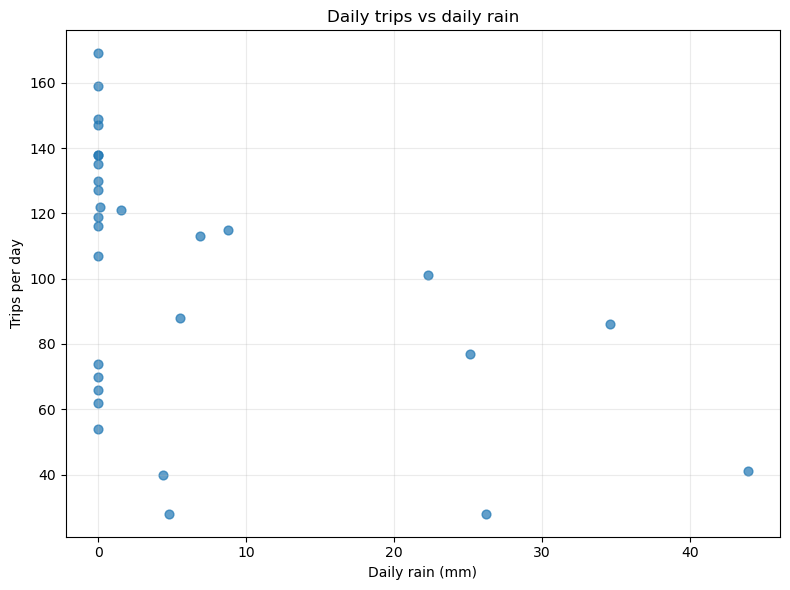

In [811]:
# Prepare daily trips and daily weather
daily_trips = compute_daily_trip_counts(trips)
daily_weather = compute_daily_weather_aggregates(weather)

# Merge on date
daily_merged = pd.merge(
    daily_trips,
    daily_weather,
    on='date',
    how='inner'
)

# Scatter: Rain (x) vs Trip count (y)
plot_scatter(
    df=daily_merged,
    x_col='rain_mm_daily',
    y_col='trip_count',
    title='Daily trips vs daily rain',
    xlabel='Daily rain (mm)',
    ylabel='Trips per day'
)

#### Trips - Average temperature

Saved scatter figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\Daily_trips_vs_mean_temperature.png


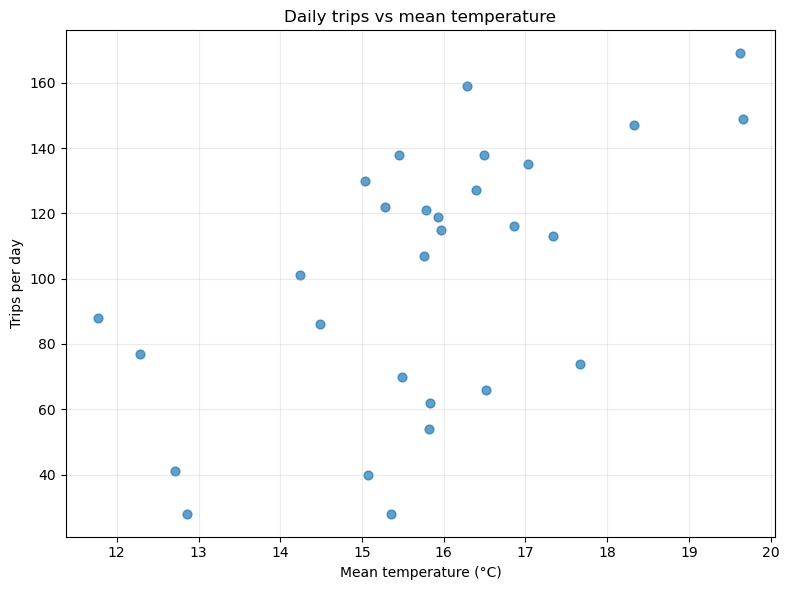

In [812]:
# Using same daily_merged from above

# Scatter: Avg temperature vs Trip count
plot_scatter(
    df=daily_merged,
    x_col='temp_c_mean',
    y_col='trip_count',
    title='Daily trips vs mean temperature',
    xlabel='Mean temperature (°C)',
    ylabel='Trips per day'
)

#### Trips by hour of day – colored by rain, sized by wind

C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\2119752122.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['datetime_hour'] = df[time_col].dt.floor('H')
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_4356\328343468.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly['datetime_hour'] = weather_hourly['datetime'].dt.floor('H')


Saved scatter figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\Trips_by_hour_of_day_colored_by_rain_sized_by_wind.png


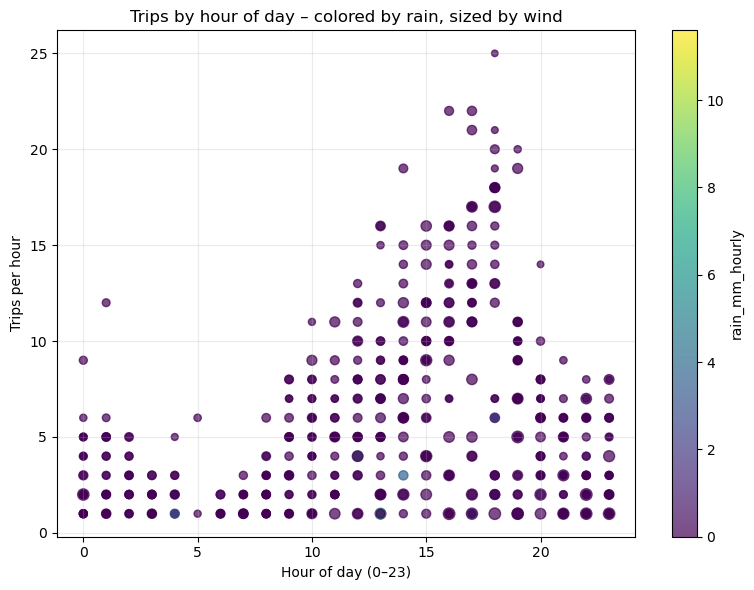

In [813]:
# Compute hourly trips
hourly_trips = compute_hourly_trip_counts(trips)

# Prepare hourly weather: aggregate to hour
weather_hourly = weather.copy()
weather_hourly['datetime_hour'] = weather_hourly['datetime'].dt.floor('H')
weather_hourly_agg = (
    weather_hourly
    .groupby('datetime_hour', as_index=False)
    .agg({
        'rain_mm': 'sum',
        'temp_c': 'mean',
        'wind_speed_ms': 'mean'
    })
    .rename(columns={
        'rain_mm': 'rain_mm_hourly',
        'temp_c': 'temp_c_hourly',
        'wind_speed_ms': 'wind_speed_hourly'
    })
)

# Merge hourly trips + weather
hourly_merged = pd.merge(
    hourly_trips,
    weather_hourly_agg,
    on='datetime_hour',
    how='inner'
)

# Add hour-of-day
hourly_merged['hour_of_day'] = hourly_merged['datetime_hour'].dt.hour

# Scatter: hour of day vs trip_count, colored by rain, sized by wind
plot_scatter(
    df=hourly_merged,
    x_col='hour_of_day',
    y_col='trip_count',
    color_col='rain_mm_hourly',
    size_col='wind_speed_hourly',
    title='Trips by hour of day – colored by rain, sized by wind',
    xlabel='Hour of day (0–23)',
    ylabel='Trips per hour'
)

#### Trips - Day of 

Saved scatter figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\Trips_vs_weekday_colored_by_daily_rain.png


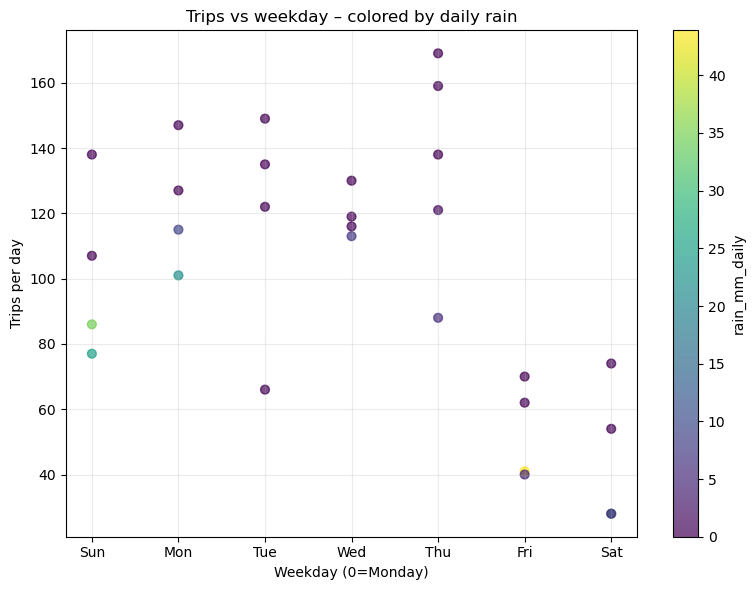

In [814]:
# Add weekday column (0 = Monday, 6 = Sunday)
daily_merged['weekday'] = (daily_merged['date'].dt.dayofweek + 1) % 7 + 1


# Scatter: weekday vs trips, colored by daily rain
plot_scatter(
    df=daily_merged,
    x_col='weekday',
    y_col='trip_count',
    color_col='rain_mm_daily',
    title='Trips vs weekday – colored by daily rain',
    xlabel='Weekday (0=Monday)',
    ylabel='Trips per day'
)


#### outlier_points

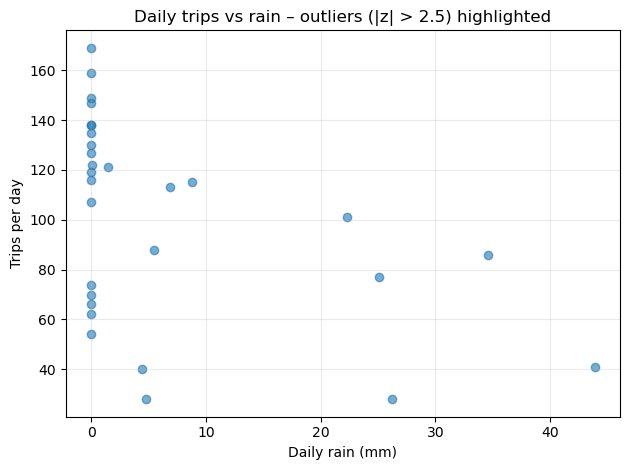

In [815]:
# Add z-score for trip_count
daily_merged['trip_count_z'] = (
    (daily_merged['trip_count'] - daily_merged['trip_count'].mean()) /
    (daily_merged['trip_count'].std(ddof=0) + 1e-9)
)

# Mark outliers (|z| > 2.5 for example)
z_thresh = 2.5
daily_merged['is_outlier'] = daily_merged['trip_count_z'].abs() > z_thresh

# Split normal vs outliers
normal_points = daily_merged[~daily_merged['is_outlier']]
outlier_points = daily_merged[daily_merged['is_outlier']]


# Normal points
plt.scatter(
    normal_points['rain_mm_daily'],
    normal_points['trip_count'],
    alpha=0.6,
)

# Outliers highlighted
plt.scatter(
    outlier_points['rain_mm_daily'],
    outlier_points['trip_count'],
    alpha=0.9,
    edgecolor='red',
    linewidth=1.5
)

plt.xlabel('Daily rain (mm)')
plt.ylabel('Trips per day')
plt.title(f'Daily trips vs rain – outliers (|z| > {z_thresh}) highlighted')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


#### Trips vs temperature – colored by rain, sized by wind

Saved scatter figure to: C:\Users\aviyaoh\Downloads\csv_and_merge_files\Graphs\Trips_vs_temperature_colored_by_rain_sized_by_wind.png


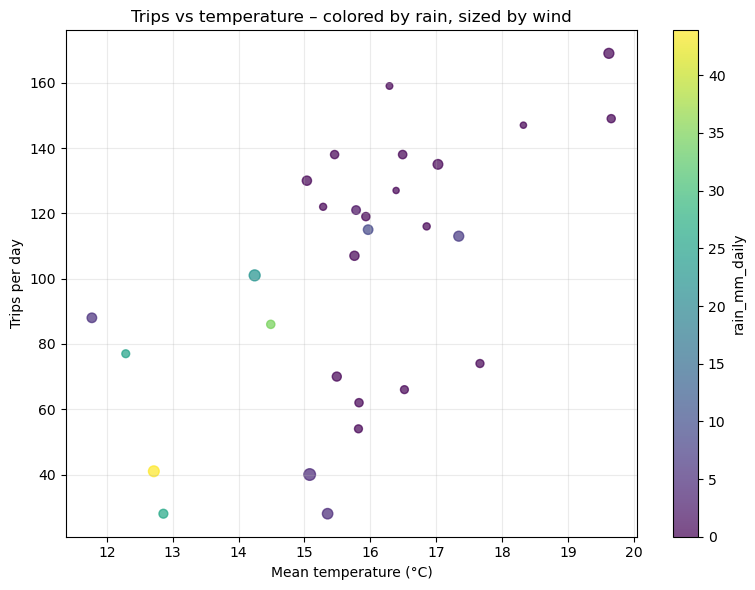

In [816]:
plot_scatter(
    df=daily_merged,
    x_col='temp_c_mean',
    y_col='trip_count',
    color_col='rain_mm_daily',
    size_col='wind_speed_mean',
    title='Trips vs temperature – colored by rain, sized by wind',
    xlabel='Mean temperature (°C)',
    ylabel='Trips per day'
)
